In [189]:
import sys
# !{sys.executable} -m pip install matplotlib

In [190]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, zero_one_loss
from sklearn.svm import SVC

In [191]:
df = pd.read_csv("./bupa/bupa.data", names=['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks', 'selector'])

In [192]:
df

,mcv,alkphos,sgpt,sgot,gammagt,drinks,selector
0,85,92,45,27,31,0.0,1
1,85,64,59,32,23,0.0,2
2,86,54,33,16,54,0.0,2
3,91,78,34,24,36,0.0,2
4,87,70,12,28,10,0.0,2
...,...,...,...,...,...,...,...
340,99,75,26,24,41,12.0,1
341,96,69,53,43,203,12.0,2
342,98,77,55,35,89,15.0,1
343,91,68,27,26,14,16.0,1


In [193]:
def main_max_rescaling(df, columns):
    for col in columns:
        pt_min = df[col].min()
        pt_max = df[col].max()
        df[col] = (df[col] - pt_min) / (pt_max - pt_min)

In [194]:
feature_columns = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks']
main_max_rescaling(df, feature_columns)

In [195]:
df

,mcv,alkphos,sgpt,sgot,gammagt,drinks,selector
0,0.526316,0.600000,0.271523,0.285714,0.089041,0.00,1
1,0.526316,0.356522,0.364238,0.350649,0.061644,0.00,2
2,0.552632,0.269565,0.192053,0.142857,0.167808,0.00,2
3,0.684211,0.478261,0.198675,0.246753,0.106164,0.00,2
4,0.578947,0.408696,0.052980,0.298701,0.017123,0.00,2
...,...,...,...,...,...,...,...
340,0.894737,0.452174,0.145695,0.246753,0.123288,0.60,1
341,0.815789,0.400000,0.324503,0.493506,0.678082,0.60,2
342,0.868421,0.469565,0.337748,0.389610,0.287671,0.75,1
343,0.684211,0.391304,0.152318,0.272727,0.030822,0.80,1


In [196]:
X = df.iloc[:, :6]
y = df['selector'].apply(lambda x: 0 if x == 1 else 1) # normalize 0, 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

https://www.datacamp.com/community/tutorials/adaboost-classifier-python

https://towardsdatascience.com/machine-learning-part-17-boosting-algorithms-adaboost-in-python-d00faac6c464

In [197]:
# Create adaboost classifer object
model = AdaBoostClassifier(n_estimators=100, learning_rate=1)
# Train Adaboost Classifer
model.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6


In [198]:
model.feature_importances_ 

array([0.12, 0.22, 0.25, 0.12, 0.17, 0.12])

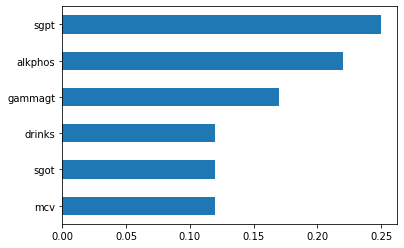

In [199]:
fi = model.feature_importances_
columns = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks']
pd.Series(fi, index=columns).sort_values()[-len(columns):].plot(kind='barh');

In [200]:
dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

In [201]:
n_estimators = 100
model = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=1,
    n_estimators=n_estimators)
model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

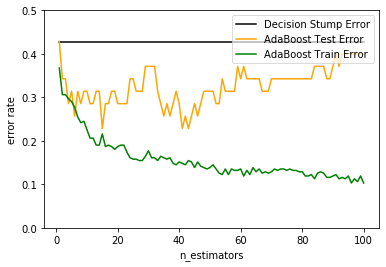

In [202]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')

model_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(model.staged_predict(X_test)):
    model_err[i] = zero_one_loss(y_pred, y_test)

model_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(model.staged_predict(X_train)):
    model_err_train[i] = zero_one_loss(y_pred, y_train)


ax.plot(np.arange(n_estimators) + 1, model_err,
    label='AdaBoost Test Error',
    color='orange')

ax.plot(np.arange(n_estimators) + 1, model_err_train,
        label='AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

In [203]:
model.estimators_[0].feature_importances_

array([0., 0., 0., 0., 1., 0.])

In [204]:
columns = ['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks']
for i in range(10):
    estimator = model.estimators_[i]
    fid = estimator.tree_.feature[0]
    thresh = estimator.tree_.threshold[0]
    print("Component %s threshhold:\t %0.2f" % (columns[fid], thresh))


Component gammagt threshhold:	 0.06
Component sgpt threshhold:	 0.12
Component alkphos threshhold:	 0.32
Component sgot threshhold:	 0.23
Component drinks threshhold:	 0.28
Component gammagt threshhold:	 0.10
Component sgpt threshhold:	 0.09
Component gammagt threshhold:	 0.01
Component mcv threshhold:	 0.64
Component sgot threshhold:	 0.53


In [205]:
from sklearn.tree.export import export_text
r = export_text(model.estimators_[0], feature_names=['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks'])
print(r)

|--- gammagt <= 0.06
|   |--- class: 0
|--- gammagt >  0.06
|   |--- class: 1



## 50 random splits

In [206]:
def shuffle_split(x, y):
    ss = ShuffleSplit(n_splits=50, train_size=0.9, test_size=0.1, random_state=0)
    data = []
    for train_index, test_index in ss.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        data.append((x_train, x_test, y_train, y_test))
    return data

In [207]:
feature = df[['mcv', 'alkphos', 'sgpt', 'sgot', 'gammagt', 'drinks']].to_numpy()
labels = df['selector'].to_numpy()
data = shuffle_split(feature, labels)

In [208]:
n_estimators = 100
model_err_train = np.zeros((n_estimators,))
model_err_test = np.zeros((n_estimators,))

for x_train, x_test, y_train, y_test in data:
    model = AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1, min_samples_leaf=1),
        learning_rate=1,
        n_estimators=n_estimators)
    model.fit(x_train, y_train)
    
    
    for i, y_pred in enumerate(model.staged_predict(x_train)):
        model_err_train[i] += zero_one_loss(y_pred, y_train)

    
    for i, y_pred in enumerate(model.staged_predict(x_test)):
        model_err_test[i] += zero_one_loss(y_pred, y_test)

# calc average
for i in range(n_estimators):
    model_err_train[i] /= len(data)
    model_err_test[i] /= len(data)



#     y_pred_50.append(y_pred)
#     res = classifier.fit(x_train, y_train)
#     y_pred = res.predict(X_test)
#     acc = metrics.accuracy_score(y_test, y_pred)
# #     print("Accuracy:", acc)
#     total_acc += acc
#     train_err.append(res.score(x_train, y_train))
#     test_err.append(res.score(x_test, y_test))
#     if best_acc < acc:
#         best = y_pred
#         best_acc = acc

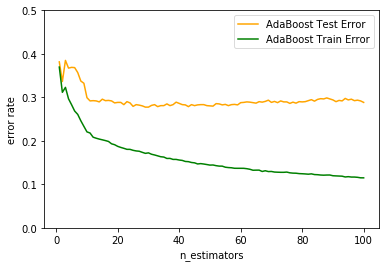

In [209]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(n_estimators) + 1, model_err_test,
    label='AdaBoost Test Error',
    color='orange')

ax.plot(np.arange(n_estimators) + 1, model_err_train,
        label='AdaBoost Train Error',
        color='green')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

# 3

In [210]:
model_10 = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=1,
    n_estimators=10,
    algorithm='SAMME')
model_10.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [211]:
model_50 = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=1,
    n_estimators=50,
    algorithm='SAMME')
model_50.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [212]:
model_100 = AdaBoostClassifier(
    base_estimator=dt_stump,
    learning_rate=1,
    n_estimators=100,
    algorithm='SAMME')
model_100.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                               

In [213]:
def plot_vals(model, X):
    fx = []
    alphas = np.array(model.estimator_weights_)
    alphas_norm = alphas / sum(alphas)
    i = 0
    rez = []
    for est in model.estimators_:
        pr = []
        pred = est.predict(X)
        pred[pred == 0] = -1
        for res in pred:
            pr.append(res * alphas_norm[i])
        rez.append(pr)
        i += 1
    rezdf = pd.DataFrame(rez)
    x_axis = []
    for col in rezdf:
        x_axis.append(rezdf[col].sum())
    x_axis = np.sort(np.array(x_axis))
    y_axis = np.arange(1, len(x_axis) + 1)/len(x_axis)
    return (x_axis, y_axis)

In [214]:
x_10, y_10 = plot_vals(model_10, X)
x_50, y_50 = plot_vals(model_50, X)
x_100, y_100 = plot_vals(model_100, X)

### Empirical cumulative distribution functions of the margins yifT(xi) after 10, 50 and 100 iterations

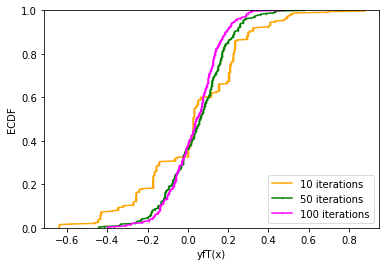

In [215]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_10, y_10,
    label='10 iterations',
    color='orange', marker=".", linestyle="-", markersize=1)

ax.plot(x_50, y_50,
        label='50 iterations',
        color='green', marker=".", linestyle="-", markersize=1)

ax.plot(x_100, y_100,
        label='100 iterations',
        color='magenta', marker=".", linestyle="-", markersize=1)

ax.set_ylim((0.0, 1.0))
ax.set_xlabel('yfT(x)')
ax.set_ylabel('ECDF')

leg = ax.legend(loc='lower right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()